# 1. Preparing Data


## 1.1 Access datasets

In [1]:
#Access datasets location
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/tfProject

/content/gdrive/MyDrive/tfProject


In [3]:
%ls

Models/      Original_data/  RNA_data/
numpy_data/  Project.ipynb   title_conference.csv


## 1.2 Import libraries

In [72]:
#!pip install tensorflow

In [73]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, MaxPooling3D, MaxPooling2D, MaxPooling1D, Conv3D, Conv2D, Conv1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

## 1.3 Create functions

### 1.3.1 DNA2RNA function (ONE TIME USED)
change DNA sequences in Original_data folder to RNA sequences stored in RNA_data folder

In [6]:
# DNA2RNA function
# change DNA in fasta format to RNA in fasta format

def DNA2RNA(fileName):
  file = open('Original_data/' + fileName + '.fasta','r')
  output_file = open('RNA_data/' + fileName + '.fasta','w')
  for line in file:
    if line[0] == ">":
      output_file.write(line)
    else:
      line = line.replace("T","U")
      output_file.write(line)
  output_file.close()
  file.close()

In [7]:
# ONE-TIME USE
# change all test and train files (DNA fasta) to RNA fasta files (taking long time)

"""
for i in range(0,10):
  DNA2RNA("Test_" + str(i))
  DNA2RNA("Train_" + str(i))
"""

'\nfor i in range(0,10):\n  DNA2RNA("Test_" + str(i))\n  DNA2RNA("Train_" + str(i))\n'

### 1.3.2 OneHotEncode function
change RNA sequences to One-Hot encode (fix-length = 750)

In [8]:
# OneHotEncode function
# change RNA sequence to one-hot matrix

MAX_LEN = 750
def OneHotEncode(Sequence):

  if len(Sequence) > MAX_LEN:
    Sequence = Sequence[:MAX_LEN]
  else:
    Sequence = Sequence + 'N'*(MAX_LEN-len(Sequence))


  oneHot = []
  for base in Sequence:
    if   base == "A":
      oneHot.append([[1],[0],[0],[0]])
    elif base == "C":
      oneHot.append([[0],[1],[0],[0]])
    elif base == "G":
      oneHot.append([[0],[0],[1],[0]])
    elif base == "U":
      oneHot.append([[0],[0],[0],[1]])
    else:
      oneHot.append([[0],[0],[0],[0]])
  return oneHot

In [9]:
"""
# testing OneHotEncode function
oneHotTmp = OneHotEncode('AANNNNUUCCG')
print(oneHotTmp)
"""

"\n# testing OneHotEncode function\noneHotTmp = OneHotEncode('AANNNNUUCCG')\nprint(oneHotTmp)\n"

### 1.3.3 ReadData
read RNA fasta file and return tuple of vector that for each vector contains input (one-hot matrix) and output (classId)

In [10]:
# Define Class2Id and Id2Class for output
ClassesList = ['5_8S_rRNA' , '5S_rRNA'    , 'CD-box'  , 'HACA-box', \
               'Intron_gpI', 'Intron_gpII', 'IRES'    , 'leader'  , \
               'miRNA'     , 'riboswitch' , 'ribozyme', 'scaRNA'  , 'tRNA']
Class2Id = {k:v for (v,k) in enumerate(ClassesList)}
Id2Class = {k:v for (k,v) in enumerate(ClassesList)}
print(Class2Id)
print(Id2Class)

{'5_8S_rRNA': 0, '5S_rRNA': 1, 'CD-box': 2, 'HACA-box': 3, 'Intron_gpI': 4, 'Intron_gpII': 5, 'IRES': 6, 'leader': 7, 'miRNA': 8, 'riboswitch': 9, 'ribozyme': 10, 'scaRNA': 11, 'tRNA': 12}
{0: '5_8S_rRNA', 1: '5S_rRNA', 2: 'CD-box', 3: 'HACA-box', 4: 'Intron_gpI', 5: 'Intron_gpII', 6: 'IRES', 7: 'leader', 8: 'miRNA', 9: 'riboswitch', 10: 'ribozyme', 11: 'scaRNA', 12: 'tRNA'}


In [11]:
# ReadData function
# read RNA fasta file and return tuple of vector that for each vector contains input (one-hot matrix) and output (classId)

def ReadData(fileName):

  data_count = 0
  class_data_count = {k:0 for k in ClassesList}
  X_data = []
  Y_data = []

  file = open('RNA_data/' + fileName + '.fasta','r')

  for idx, line in enumerate(file):
    
    # remove '\n'
    line = line.strip()

    # if line is header then increment data_count, add class_data_count, and fill RNA class (as a vector) in Y_data
    if line[0] == ">":
      (RNA_id, RNA_class) = line.split()

      #increment data_count
      data_count += 1

      #add class_data_count
      class_data_count[RNA_class]+=1
      
      #fill RNA class (as a vector) in Y_data
      classVector = [0]*13
      classVector[Class2Id[RNA_class]] = 1
      Y_data.append(classVector)


    # if line is RNA sequence then fill One-hot encoder in X_data
    else:
      sequence = line
      oneHot = OneHotEncode(sequence)
      X_data.append(oneHot)


  file.close()
  X_data = np.array(X_data)
  Y_data = np.array(Y_data)
  print(f"Read {fileName}")
  print("total data :", data_count)
  print("data count in each class :", class_data_count)
  print(f"input  shape :", X_data.shape)
  print(f"output shape :", Y_data.shape)
  print("================================")
  return (X_data, Y_data)

In [12]:
# testing ReadData function
"""
X_test, Y_test = ReadData("Test_0")
"""

'\nX_test, Y_test = ReadData("Test_0")\n'

### 1.3.4 ReadSplitData
read RNA fasta file and return tuple of dict that \
for each dict contains input (one-hot matrix) and output (classId) which classified by key = classId \
We only use this function with Test data

In [13]:
# ReadSplitData
# read RNA fasta file and return tuple of list that for each list contains input (one-hot matrix) and output (classID) which classified by key = classID
def ReadSplitData(fileName):

  data_count = 0
  class_data_count = {k:0 for k in ClassesList}
  X_data_split = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
  Y_data_split = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

  file = open('RNA_data/' + fileName + '.fasta','r')

  for idx, line in enumerate(file):
    # remove '\n'
    line = line.strip()


    # if line is header then increment data_count, add class_data_count, and fill RNA class (as a vector) in Y_data_split[classId]
    if line[0] == ">":
      (RNA_id, RNA_class) = line.split()
      classID = Class2Id[RNA_class]

      #increment data_count
      data_count += 1

      #add class_data_count
      class_data_count[RNA_class]+=1
      
      #fill RNA class (as a vector) in Y_data
      Class = [0]*13
      Class[Class2Id[RNA_class]] = 1
      Y_data_split[classID].append(Class)


    # if line is RNA sequence then fill One-hot encoder in X_data_split[classID]
    else:
      Seq = line
      oneHot = OneHotEncode(Seq)
      X_data_split[classID].append(oneHot)

  file.close()
  for classID in range(13):
    X_data_split[classID] = np.array(X_data_split[classID])
    Y_data_split[classID] = np.array(Y_data_split[classID])
  print(f"Read {fileName}")
  print("total data :", data_count)
  print("data count in each class :", class_data_count)
  for classID in range(13):
    print("classID :", classID)
    print(f"input  shape :", X_data_split[classID].shape)
    print(f"output shape :", Y_data_split[classID].shape)
  print("================================")
  return (np.array(X_data_split), np.array(Y_data_split))

In [14]:
# testing ReadSplitData function
"""
X_test_split, Y_test_split = ReadSplitData("Test_0")
"""

'\nX_test_split, Y_test_split = ReadSplitData("Test_0")\n'

### 1.3.5 KmersEncode
change RNA sequences to K-mers encode (fix-length = 750) \
this function change sequence to kmers then convert to matrix that contain RNABaseID (as a vector) \
(change 'A' to [[1],[0],[0],[0]] , 'U' to [[0],[1],[0],[0]], 'C' to [[0],[0],[1],[0]], 'G' to [[0],[0],[0],[1]], else to [[0],[0],[0],[0]]) \
Example : 'AAUG' with 3-mers \
-> ['AAU', 'AUG']]\
-> [([1000],[1000],[0100]),([1000],[0100],[0001])]

In [15]:
MAX_LEN = 750
def KmersEncode(Sequence, k=3):
  rnaBaseID = {'A':[[1],[0],[0],[0]], 'U':[[0],[1],[0],[0]], 'C':[[0],[0],[1],[0]], 'G':[[0],[0],[0],[1]]}
  kmers = []
  if len(Sequence) > MAX_LEN:
    Sequence = Sequence[:MAX_LEN]
  else:
    Sequence = Sequence + 'N'*(MAX_LEN-len(Sequence))

  for step in range(0,len(Sequence)-k+1):
    kmerSequence = Sequence[step:step+k]
    kmer = []
    for pos in range(k):
      base = kmerSequence[pos]
      if base not in rnaBaseID:
        kmer.append([[0],[0],[0],[0]])
      else:
        kmer.append(rnaBaseID[kmerSequence[pos]])
    kmers.append(kmer)
  return kmers

In [16]:
#testing KmersEncode function
"""
print(KmersEncode("AAU"))
"""

'\nprint(KmersEncode("AAU"))\n'

### 1.3.6 ReadKmersData
read RNA fasta file and return tuple of vector that for each vector contains input (Kmer matrix) and output (classId)

In [17]:
# ReadKmersData
# read RNA fasta file and return tuple of vector that for each vector contains input (Kmers vector) and output (classId)
def ReadKmersData(fileName, k=3):
  data_count = 0
  class_data_count = {k:0 for k in ClassesList}
  X_data = []
  Y_data = []

  file = open('RNA_data/' + fileName + '.fasta','r')

  for idx, line in enumerate(file):
    # remove '\n'
    line = line.strip()


    # if line is header then increment data_count, add class_data_count, and fill RNA class (as a vector) in Y_data
    if line[0] == ">":
      (RNA_id, RNA_class) = line.split()

      #increment data_count
      data_count += 1

      #add class_data_count
      class_data_count[RNA_class]+=1
      
      #fill RNA class (as a vector) in Y_data
      Class = [0]*13
      Class[Class2Id[RNA_class]] = 1
      Y_data.append(Class)


    # if line is RNA sequence then fill Kmers encoder in X_data
    else:
      Seq = line
      kmers = KmersEncode(Seq, k)
      X_data.append(kmers)

  file.close()
  X_data = np.array(X_data)
  Y_data = np.array(Y_data)
  print(f"Read {fileName}")
  print("total data :", data_count)
  print("data count in each class :", class_data_count)
  print(f"input  shape :", X_data.shape)
  print(f"output shape :", Y_data.shape)
  print("================================")
  return (X_data, Y_data)
  

In [18]:
# testing ReadKmersData function

X_test_kmer, Y_test_kmer = ReadKmersData("Test_0", k=3)


Read Test_0
total data : 632
data count in each class : {'5_8S_rRNA': 50, '5S_rRNA': 50, 'CD-box': 50, 'HACA-box': 50, 'Intron_gpI': 50, 'Intron_gpII': 50, 'IRES': 32, 'leader': 50, 'miRNA': 50, 'riboswitch': 50, 'ribozyme': 50, 'scaRNA': 50, 'tRNA': 50}
input  shape : (632, 748, 3, 4, 1)
output shape : (632, 13)


### 1.3.7 ReadKmersSplitData
read RNA fasta file and return tuple of dict that \
for each dict contains input (Kmer matrix) and output (classId) which classified by key = classId \
We only use this function with Test data

In [19]:
# ReadKmersSplitData
# read RNA fasta file and return tuple of list that for each list contains input (Kmers matrix) and output (classId) which classified by key = classID
def ReadKmersSplitData(fileName, k=3):
  data_count = 0
  class_data_count = {k:0 for k in ClassesList}
  X_data_split = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
  Y_data_split = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

  file = open('RNA_data/' + fileName + '.fasta','r')

  for idx, line in enumerate(file):
    # remove '\n'
    line = line.strip()


    # if line is header then increment data_count, add class_data_count, and fill RNA class (as a vector) in Y_data_split[classId]
    if line[0] == ">":
      (RNA_id, RNA_class) = line.split()
      classID = Class2Id[RNA_class]

      #increment data_count
      data_count += 1

      #add class_data_count
      class_data_count[RNA_class]+=1
      
      #fill RNA class (as a vector) in Y_data
      Class = [0]*13
      Class[Class2Id[RNA_class]] = 1
      Y_data_split[classID].append(Class)


    # if line is RNA sequence then fill One-hot encoder in X_data
    else:
      Seq = line
      kmers = KmersEncode(Seq, k)
      X_data_split[classID].append(kmers)


  file.close()
  for classId in range(13):
    X_data_split[classId] = np.array(X_data_split[classId])
    Y_data_split[classId] = np.array(Y_data_split[classId])
  print(f"Read {fileName}")
  print("total data :", data_count)
  print("data count in each class :", class_data_count)
  for classID in range(13):
    print("classID :", classID)
    print(f"input  shape :", X_data_split[classID].shape)
    print(f"output shape :", Y_data_split[classID].shape)
  print("================================")
  return (X_data_split, Y_data_split)

In [20]:
# testing ReadKmersSplitData function
"""
X_test_split, Y_test_split = ReadKmersSplitData("Test_0", k=3)
"""

'\nX_test_split, Y_test_split = ReadKmersSplitData("Test_0", k=3)\n'

# 2. Train Model


## 2.1 Load Datasets

### 2.1.1 Make npy files using np.save() (ONE TIME USED)

#### 2.1.1.1 One-Hot data (Test&Train)

In [21]:
# ONE-TIME USE
"""
#load data using ReadData (test and train data)
X_train = []; Y_train = []; X_test = []; Y_test = []
for fileID in range(10):
  X_test_tmp, Y_test_tmp = ReadData(f"Test_{fileID}")
  X_test.append(X_test_tmp)
  Y_test.append(Y_test_tmp)
  X_train_tmp, Y_train_tmp = ReadData(f"Train_{fileID}")
  X_train.append(X_train_tmp)
  Y_train.append(Y_train_tmp)

#Save npy data to folder numpy_data
%cd numpy_data
for fileID in range(10):
  np.save(f"X_train_{fileID}", X_train[fileID])
  np.save(f"Y_train_{fileID}", Y_train[fileID])
  np.save(f"X_test_{fileID}" , X_test[fileID])
  np.save(f"Y_test_{fileID}" , Y_test[fileID])
%cd ..
"""

'\n#load data using ReadData (test and train data)\nX_train = []; Y_train = []; X_test = []; Y_test = []\nfor fileID in range(10):\n  X_test_tmp, Y_test_tmp = ReadData(f"Test_{fileID}")\n  X_test.append(X_test_tmp)\n  Y_test.append(Y_test_tmp)\n  X_train_tmp, Y_train_tmp = ReadData(f"Train_{fileID}")\n  X_train.append(X_train_tmp)\n  Y_train.append(Y_train_tmp)\n\n#Save npy data to folder numpy_data\n%cd numpy_data\nfor fileID in range(10):\n  np.save(f"X_train_{fileID}", X_train[fileID])\n  np.save(f"Y_train_{fileID}", Y_train[fileID])\n  np.save(f"X_test_{fileID}" , X_test[fileID])\n  np.save(f"Y_test_{fileID}" , Y_test[fileID])\n%cd ..\n'

#### 2.1.1.2 One-Hot split data (Test)

In [22]:
# ONE-TIME USE
"""
#load data using ReadSplitData (test data)

X_test_split = []; Y_test_split = []
for fileID in range(10):
  X_test_tmp, Y_test_tmp = ReadSplitData(f"Test_{fileID}")
  X_test_split.append(X_test_tmp)
  Y_test_split.append(Y_test_tmp)

#Save npy data to folder numpy_data
%cd numpy_data
for fileID in range(10):
  np.save(f"X_test_split_{fileID}" , X_test_split[fileID])
  np.save(f"Y_test_split_{fileID}" , Y_test_split[fileID])
%cd ..
"""

'\n#load data using ReadSplitData (test data)\n\nX_test_split = []; Y_test_split = []\nfor fileID in range(10):\n  X_test_tmp, Y_test_tmp = ReadSplitData(f"Test_{fileID}")\n  X_test_split.append(X_test_tmp)\n  Y_test_split.append(Y_test_tmp)\n\n#Save npy data to folder numpy_data\n%cd numpy_data\nfor fileID in range(10):\n  np.save(f"X_test_split_{fileID}" , X_test_split[fileID])\n  np.save(f"Y_test_split_{fileID}" , Y_test_split[fileID])\n%cd ..\n'

#### 2.1.1.3 Kmers data (Test&Train)

In [23]:
# ONE-TIME USE
"""
#load data using ReadKmersData (test and train data)
X_train_kmers = []; Y_train_kmers = []; X_test_kmers = []; Y_test_kmers = []
for fileID in range(10):
  X_test_kmers_tmp, Y_test_kmers_tmp = ReadKmersData(f"Test_{fileID}")
  X_test_kmers.append(X_test_kmers_tmp)
  Y_test_kmers.append(Y_test_kmers_tmp)
  X_train_kmers_tmp, Y_train_kmers_tmp = ReadKmersData(f"Train_{fileID}")
  X_train_kmers.append(X_train_kmers_tmp)
  Y_train_kmers.append(Y_train_kmers_tmp)

#Save npy data to folder numpy_data
%cd numpy_data
for fileID in range(10):
  np.save(f"X_train_kmers_{fileID}", X_train_kmers[fileID])
  np.save(f"Y_train_kmers_{fileID}", Y_train_kmers[fileID])
  np.save(f"X_test_kmers_{fileID}" , X_test_kmers[fileID])
  np.save(f"Y_test_kmers_{fileID}" , Y_test_kmers[fileID])
%cd ..
"""

'\n#load data using ReadKmersData (test and train data)\nX_train_kmers = []; Y_train_kmers = []; X_test_kmers = []; Y_test_kmers = []\nfor fileID in range(10):\n  X_test_kmers_tmp, Y_test_kmers_tmp = ReadKmersData(f"Test_{fileID}")\n  X_test_kmers.append(X_test_kmers_tmp)\n  Y_test_kmers.append(Y_test_kmers_tmp)\n  X_train_kmers_tmp, Y_train_kmers_tmp = ReadKmersData(f"Train_{fileID}")\n  X_train_kmers.append(X_train_kmers_tmp)\n  Y_train_kmers.append(Y_train_kmers_tmp)\n\n#Save npy data to folder numpy_data\n%cd numpy_data\nfor fileID in range(10):\n  np.save(f"X_train_kmers_{fileID}", X_train_kmers[fileID])\n  np.save(f"Y_train_kmers_{fileID}", Y_train_kmers[fileID])\n  np.save(f"X_test_kmers_{fileID}" , X_test_kmers[fileID])\n  np.save(f"Y_test_kmers_{fileID}" , Y_test_kmers[fileID])\n%cd ..\n'

#### 2.1.1.4 Kmers split data  (Test)

In [24]:
# ONE-TIME USE
"""
#load data using ReadKmersSplitData (test data)
X_test_kmers_split = []; Y_test_kmers_split = []
for fileID in range(10):
  X_test_kmers_split_tmp, Y_test_kmers_split_tmp = ReadKmersSplitData(f"Test_{fileID}")
  X_test_kmers_split.append(X_test_kmers_split_tmp)
  Y_test_kmers_split.append(Y_test_kmers_split_tmp)

#Save npy data to folder numpy_data
%cd numpy_data
for fileID in range(10):
  np.save(f"X_test_kmers_split_{fileID}" , X_test_kmers_split[fileID])
  np.save(f"Y_test_kmers_split_{fileID}" , Y_test_kmers_split[fileID])
%cd ..
"""

'\n#load data using ReadKmersSplitData (test data)\nX_test_kmers_split = []; Y_test_kmers_split = []\nfor fileID in range(10):\n  X_test_kmers_split_tmp, Y_test_kmers_split_tmp = ReadKmersSplitData(f"Test_{fileID}")\n  X_test_kmers_split.append(X_test_kmers_split_tmp)\n  Y_test_kmers_split.append(Y_test_kmers_split_tmp)\n\n#Save npy data to folder numpy_data\n%cd numpy_data\nfor fileID in range(10):\n  np.save(f"X_test_kmers_split_{fileID}" , X_test_kmers_split[fileID])\n  np.save(f"Y_test_kmers_split_{fileID}" , Y_test_kmers_split[fileID])\n%cd ..\n'


### 2.1.2 Load data from npy files


#### 2.1.2.1 One-Hot data

In [26]:
#Load npy data from folder numpy_data (test and train data)
%cd numpy_data
X_train = []; Y_train = []; X_test = []; Y_test = []
for fileID in range(10):
  X_test_tmp = np.load(f"X_test_{fileID}.npy", allow_pickle=True)
  X_test.append(X_test_tmp)
  Y_test_tmp = np.load(f"Y_test_{fileID}.npy", allow_pickle=True)
  Y_test.append(Y_test_tmp)
  X_train_tmp = np.load(f"X_train_{fileID}.npy", allow_pickle=True)
  X_train.append(X_train_tmp)
  Y_train_tmp = np.load(f"Y_train_{fileID}.npy", allow_pickle=True)
  Y_train.append(Y_train_tmp)
%cd ..

/content/gdrive/My Drive/tfProject/numpy_data
/content/gdrive/My Drive/tfProject


#### 2.1.2.2 One-Hot split data

In [27]:
#Load npy data from folder numpy_data (test_split data)
%cd numpy_data
X_test_split = []; Y_test_split = []
for fileID in range(10):
  X_test_split_tmp = np.load(f"X_test_split_{fileID}.npy", allow_pickle=True)
  X_test_split.append(X_test_split_tmp)
  Y_test_split_tmp = np.load(f"Y_test_split_{fileID}.npy", allow_pickle=True)
  Y_test_split.append(Y_test_split_tmp)
%cd ..

/content/gdrive/My Drive/tfProject/numpy_data
/content/gdrive/My Drive/tfProject


#### 2.1.2.3 Kmers data

In [28]:
#Load npy data from folder numpy_data (test and train data)
%cd numpy_data
X_train_kmers = []; Y_train_kmers = []; X_test_kmers = []; Y_test_kmers = []
for fileID in range(10):
  X_test_kmers_tmp = np.load(f"X_test_kmers_{fileID}.npy", allow_pickle=True)
  X_test_kmers.append(X_test_kmers_tmp)
  Y_test_kmers_tmp = np.load(f"Y_test_kmers_{fileID}.npy", allow_pickle=True)
  Y_test_kmers.append(Y_test_kmers_tmp)
  X_train_kmers_tmp = np.load(f"X_train_kmers_{fileID}.npy", allow_pickle=True)
  X_train_kmers.append(X_train_kmers_tmp)
  Y_train_kmers_tmp = np.load(f"Y_train_kmers_{fileID}.npy", allow_pickle=True)
  Y_train_kmers.append(Y_train_kmers_tmp)
%cd ..

/content/gdrive/My Drive/tfProject/numpy_data
/content/gdrive/MyDrive/tfProject


#### 2.1.2.4 Kmers split data

In [29]:
#Load npy data from folder numpy_data (test split data)
%cd numpy_data
X_test_kmers_split = []; Y_test_kmers_split = []
for fileID in range(10):
  X_test_kmers_split_tmp = np.load(f"X_test_kmers_split_{fileID}.npy", allow_pickle=True)
  X_test_kmers_split.append(X_test_kmers_split_tmp)
  Y_test_kmers_split_tmp = np.load(f"Y_test_kmers_split_{fileID}.npy", allow_pickle=True)
  Y_test_kmers_split.append(Y_test_kmers_split_tmp)
%cd ..

/content/gdrive/MyDrive/tfProject/numpy_data
/content/gdrive/My Drive/tfProject


### 2.1.3 Check data shape

In [30]:
#check shape of every dataset
for fileID in range(1):
  print(f"fileID = {fileID}")
  print("Train File         :", X_train[fileID].shape, Y_train[fileID].shape)
  print("Test  File         :", X_test[fileID].shape , Y_test[fileID].shape)
  for classID in range(13):
    print(f"Test  classID = {classID:02d} :", X_test_split[fileID][classID].shape, Y_test_split[fileID][classID].shape)
  print('--------------------------------------------------------------')
  print("Train kmers File         :", X_train_kmers[fileID].shape, Y_train_kmers[fileID].shape)
  print("Test  kmers File         :", X_test_kmers[fileID].shape , Y_test_kmers[fileID].shape)
  for classID in range(13):
    print(f"Test  kmers classID = {classID:02d} :", X_test_kmers_split[fileID][classID].shape, Y_test_kmers_split[fileID][classID].shape)

fileID = 0
Train File         : (5688, 750, 4, 1) (5688, 13)
Test  File         : (632, 750, 4, 1) (632, 13)
Test  classID = 00 : (50, 750, 4, 1) (50, 13)
Test  classID = 01 : (50, 750, 4, 1) (50, 13)
Test  classID = 02 : (50, 750, 4, 1) (50, 13)
Test  classID = 03 : (50, 750, 4, 1) (50, 13)
Test  classID = 04 : (50, 750, 4, 1) (50, 13)
Test  classID = 05 : (50, 750, 4, 1) (50, 13)
Test  classID = 06 : (32, 750, 4, 1) (32, 13)
Test  classID = 07 : (50, 750, 4, 1) (50, 13)
Test  classID = 08 : (50, 750, 4, 1) (50, 13)
Test  classID = 09 : (50, 750, 4, 1) (50, 13)
Test  classID = 10 : (50, 750, 4, 1) (50, 13)
Test  classID = 11 : (50, 750, 4, 1) (50, 13)
Test  classID = 12 : (50, 750, 4, 1) (50, 13)
--------------------------------------------------------------
Train kmers File         : (5688, 748, 3, 4, 1) (5688, 13)
Test  kmers File         : (632, 748, 3, 4, 1) (632, 13)
Test  kmers classID = 00 : (50, 748, 3, 4, 1) (50, 13)
Test  kmers classID = 01 : (50, 748, 3, 4, 1) (50, 13)
Test

### 2.1.4 Change data to type float32

In [31]:
for fileID in range(10):
  X_train[fileID] = X_train[fileID].astype('float32')
  Y_train[fileID] = Y_train[fileID].astype('float32')
  X_test[fileID] = X_test[fileID].astype('float32')
  Y_test[fileID] = Y_test[fileID].astype('float32')
  #----------------------------------------------------#
  X_train_kmers[fileID] = X_train_kmers[fileID].astype('float32')
  Y_train_kmers[fileID] = Y_train_kmers[fileID].astype('float32')
  X_test_kmers[fileID] = X_test_kmers[fileID].astype('float32')
  Y_test_kmers[fileID] = Y_test_kmers[fileID].astype('float32')

  for classID in range(13):
    X_test_split[fileID][classID] = X_test_split[fileID][classID].astype('float32')
    Y_test_split[fileID][classID] = Y_test_split[fileID][classID].astype('float32')
    #----------------------------------------------------#
    X_test_kmers_split[fileID][classID] = X_test_kmers_split[fileID][classID].astype('float32')
    Y_test_kmers_split[fileID][classID] = Y_test_kmers_split[fileID][classID].astype('float32')

## 2.2 Model configuration

### 2.2.1 Model type_1 (One-hot with CNN)

In [32]:
# Model t1 configuration
matrix_width_t1, matrix_height_t1 = MAX_LEN, 4
batch_size_t1 = 250
no_epochs_t1 = 25
no_classes_t1 = 13
validation_split_t1 = 0.1
verbosity_t1 = 1
input_shape_t1 = (matrix_width_t1, matrix_height_t1, 1)

### 2.2.1 Model type_2 (3-mers with CNN)

In [33]:
# Model t2 configuration
tensor_width_t2, tensor_height_t2, tensor_depth_t2 = MAX_LEN-3+1, 3, 4
batch_size_t2 = 250
no_epochs_t2 = 20
no_classes_t2 = 13
validation_split_t2 = 0.1
verbosity_t2 = 1
input_shape_t2 = (tensor_width_t2, tensor_height_t2, tensor_depth_t2, 1)

## 2.3 Create Model

### 2.3.1 version 1 (Not in Benchmark)

In [34]:
"""
def getModel():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 1)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(4, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 1)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(no_classes, activation='softmax'))
  return model
model = getModel()
model.summary()
"""

"\ndef getModel():\n  model = Sequential()\n  model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape))\n  model.add(MaxPooling2D(pool_size=(2, 1)))\n  model.add(Dropout(0.25))\n  model.add(Conv2D(64, kernel_size=(4, 1), activation='relu'))\n  model.add(MaxPooling2D(pool_size=(2, 1)))\n  model.add(Dropout(0.25))\n  model.add(Flatten())\n  model.add(Dense(256, activation='relu'))\n  model.add(Dense(no_classes, activation='softmax'))\n  return model\nmodel = getModel()\nmodel.summary()\n"

### 2.3.2 Model type_1 (One-hot with CNN)

In [35]:
def getModel_t1():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 4), activation='relu', input_shape=input_shape_t1))
  model.add(MaxPooling2D(pool_size=(2, 1)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 1)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(no_classes_t1, activation='softmax'))
  return model

In [36]:
model_t1 = getModel_t1()

In [37]:
model_t1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 748, 1, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 374, 1, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 374, 1, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 372, 1, 64)        6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 186, 1, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 186, 1, 64)        0

### 2.3.3 Model type_2 (3-mers with CNN)

In [38]:
def getModel_t2():
  model = Sequential()
  model.add(Conv3D(32, kernel_size=(3, 3, 4), activation='relu', input_shape=input_shape_t2))
  model.add(MaxPooling3D(pool_size=(2, 1, 1)))
  model.add(Dropout(0.25))
  model.add(Conv3D(32, kernel_size=(3, 1, 1), activation='relu', input_shape=input_shape_t2))
  model.add(MaxPooling3D(pool_size=(2, 1, 1)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(no_classes_t2, activation='softmax'))
  return model

In [39]:
model_t2 = getModel_t2()

In [40]:
model_t2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 746, 1, 1, 32)     1184      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 373, 1, 1, 32)    0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 373, 1, 1, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 371, 1, 1, 32)     3104      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 185, 1, 1, 32)    0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 185, 1, 1, 32)    

## 2.4 Compile and Fit Model (ONE TIME USED)

### 2.4.1 Model type_1 (One-hot with CNN)

In [43]:
"""
model_t1.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])
model_t1.fit(
    X_train[0], Y_train[0],
    batch_size=batch_size_t1,
    epochs=no_epochs_t1,
    verbose=verbosity_t1,
    validation_split=validation_split_t1)
"""

"\nmodel_t1.compile(\n    loss = tf.keras.losses.categorical_crossentropy,\n    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),\n    metrics=['accuracy'])\nmodel_t1.fit(\n    X_train[0], Y_train[0],\n    batch_size=batch_size_t1,\n    epochs=no_epochs_t1,\n    verbose=verbosity_t1,\n    validation_split=validation_split_t1)\n"

### 2.4.1 Model type_2 (3-mers with CNN)

In [46]:
"""
model_t2.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])
model_t2.fit(
    X_train_kmers[0], Y_train_kmers[0],
    batch_size=batch_size_t2,
    epochs=no_epochs_t2,
    verbose=verbosity_t2,
    validation_split=validation_split_t2)
"""

"\nmodel_t2.compile(\n    loss = tf.keras.losses.categorical_crossentropy,\n    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),\n    metrics=['accuracy'])\nmodel_t2.fit(\n    X_train_kmers[0], Y_train_kmers[0],\n    batch_size=batch_size_t2,\n    epochs=no_epochs_t2,\n    verbose=verbosity_t2,\n    validation_split=validation_split_t2)\n"

## 2.5 Evaluate


### 2.5.1 Evaluate Test data


#### 2.5.1.1 Model type_1 (One-hot with CNN)

In [47]:
"""
#Test model t1 on file Test_0
score_t1 = model_t1.evaluate(X_test[0], Y_test[0], verbose=0)
print(f'Test loss: {score_t1[0]:.16f} / Test accuracy: {score_t1[1]:.16f}')
"""

"\n#Test model t1 on file Test_0\nscore_t1 = model_t1.evaluate(X_test[0], Y_test[0], verbose=0)\nprint(f'Test loss: {score_t1[0]:.16f} / Test accuracy: {score_t1[1]:.16f}')\n"

#### 2.5.1.2 Model type_2 (3-mers with CNN)

In [48]:
"""
#Test model t2 on file Test_0
score_t2 = model_t2.evaluate(X_test_kmers[0], Y_test_kmers[0], verbose=0)
print(f'Test loss: {score_t2[0]:.16f} / Test accuracy: {score_t2[1]:.16f}')
"""

"\n#Test model t2 on file Test_0\nscore_t2 = model_t2.evaluate(X_test_kmers[0], Y_test_kmers[0], verbose=0)\nprint(f'Test loss: {score_t2[0]:.16f} / Test accuracy: {score_t2[1]:.16f}')\n"

### 2.5.2 Evaluate Test split data (by ClassID)


#### 2.5.1.1 Model type_1 (One-hot with CNN)

In [49]:
"""
#Test on file Test_0
score_classes_t1 = []
for classID in range(13):
  score_class = model_t1.evaluate(X_test_split[0][classID], Y_test_split[0][classID], verbose=0)
  score_classes_t1.append(score_class)

for classID in range(13):
  print(f'ClassId : {classID:02d} / Test loss: {score_classes_t1[classID][0]:.16f} / Test accuracy: {score_classes_t1[classID][1]:.16f}')
"""

"\n#Test on file Test_0\nscore_classes_t1 = []\nfor classID in range(13):\n  score_class = model_t1.evaluate(X_test_split[0][classID], Y_test_split[0][classID], verbose=0)\n  score_classes_t1.append(score_class)\n\nfor classID in range(13):\n  print(f'ClassId : {classID:02d} / Test loss: {score_classes_t1[classID][0]:.16f} / Test accuracy: {score_classes_t1[classID][1]:.16f}')\n"

#### 2.5.1.2 Model type_2 (3-mers with CNN)

In [50]:
"""
#Test on file Test_0
score_classes_t2 = []
for classID in range(13):
  score_class = model_t2.evaluate(X_test_kmers_split[0][classID], Y_test_kmers_split[0][classID], verbose=0)
  score_classes_t2.append(score_class)

for classID in range(13):
  print(f'ClassId : {classID:02d} / Test loss: {score_classes_t2[classID][0]:.16f} / Test accuracy: {score_classes_t2[classID][1]:.16f}')
"""

"\n#Test on file Test_0\nscore_classes_t2 = []\nfor classID in range(13):\n  score_class = model_t2.evaluate(X_test_kmers_split[0][classID], Y_test_kmers_split[0][classID], verbose=0)\n  score_classes_t2.append(score_class)\n\nfor classID in range(13):\n  print(f'ClassId : {classID:02d} / Test loss: {score_classes_t2[classID][0]:.16f} / Test accuracy: {score_classes_t2[classID][1]:.16f}')\n"

# 3. Evaluate Model using 10-fold cross validation Testing

## 3.1 Train models with 10 datasets individually


### 3.1.1 version 1 (Not in benchmark)
This is the first model I've train.

In [51]:
"""
# ONE-TIME USE
# Train 10 models
models = []
for i in range(10):
  model = getModel()

  model.compile(
    loss=tensorflow.keras.losses.categorical_crossentropy,
    optimizer=tensorflow.keras.optimizers.Adam(),
    metrics=['accuracy'])
  
  model.fit(
    X_train[i], Y_train[i],
    batch_size=batch_size,
    epochs=no_epochs,
    verbose=verbosity,
    validation_split=validation_split)
  models.append(model)
"""

"\n# ONE-TIME USE\n# Train 10 models\nmodels = []\nfor i in range(10):\n  model = getModel()\n\n  model.compile(\n    loss=tensorflow.keras.losses.categorical_crossentropy,\n    optimizer=tensorflow.keras.optimizers.Adam(),\n    metrics=['accuracy'])\n  \n  model.fit(\n    X_train[i], Y_train[i],\n    batch_size=batch_size,\n    epochs=no_epochs,\n    verbose=verbosity,\n    validation_split=validation_split)\n  models.append(model)\n"

In [52]:
"""
# ONE-TIME USE
# Save 10 models
%cd Models
for i in range(10):
  models[i].save(f"model_{i}")
%cd ..
"""

'\n# ONE-TIME USE\n# Save 10 models\n%cd Models\nfor i in range(10):\n  models[i].save(f"model_{i}")\n%cd ..\n'

In [53]:
"""
# Load 10 models
%cd Models
models = []
for i in range(10):
  model = tf.keras.models.load_model(f"model_{i}")
  models.append(model)
%cd ..
"""

'\n# Load 10 models\n%cd Models\nmodels = []\nfor i in range(10):\n  model = tf.keras.models.load_model(f"model_{i}")\n  models.append(model)\n%cd ..\n'

### 3.1.2 Model type_1 (One-hot with CNN)

In [133]:
"""
# ONE-TIME USE
# Train 10 models t1
models_t1 = []
for i in range(10):
  model = getModel_t1()

  model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])
  
  model.fit(
    X_train[i], Y_train[i],
    batch_size=batch_size_t1,
    epochs=no_epochs_t1,
    verbose=verbosity_t1,
    validation_split=validation_split_t1)
  models_t1.append(model)

# Save 10 models t1
%cd Models
for i in range(10):
  models_t1[i].save(f"model_t1_{i}")
%cd ..
"""

Epoch 1/25
21/21 [==============================] - 10s 441ms/step - loss: 1.9589 - accuracy: 0.3403 - val_loss: 1.7138 - val_accuracy: 0.4376
Epoch 2/25
21/21 [==============================] - 9s 428ms/step - loss: 1.4323 - accuracy: 0.5235 - val_loss: 1.3331 - val_accuracy: 0.5747
Epoch 3/25
21/21 [==============================] - 9s 437ms/step - loss: 1.0939 - accuracy: 0.6470 - val_loss: 1.0703 - val_accuracy: 0.6573
Epoch 4/25
21/21 [==============================] - 9s 451ms/step - loss: 0.8890 - accuracy: 0.7130 - val_loss: 0.9353 - val_accuracy: 0.7083
Epoch 5/25
21/21 [==============================] - 9s 441ms/step - loss: 0.7780 - accuracy: 0.7494 - val_loss: 0.9041 - val_accuracy: 0.7065
Epoch 6/25
21/21 [==============================] - 9s 425ms/step - loss: 0.6807 - accuracy: 0.7888 - val_loss: 0.8145 - val_accuracy: 0.7311
Epoch 7/25
21/21 [==============================] - 9s 430ms/step - loss: 0.6094 - accuracy: 0.8119 - val_loss: 0.7925 - val_accuracy: 0.7575
Epoch

In [54]:
# Load 10 models t1
%cd Models
models_t1 = []
for i in range(10):
  model = tf.keras.models.load_model(f"model_t1_{i}")
  models_t1.append(model)
%cd ..

/content/gdrive/My Drive/tfProject/Models
/content/gdrive/My Drive/tfProject


### 3.1.3 Model type_2 (3-mers with CNN)

In [59]:
"""
# ONE-TIME USE
# Train 10 models t2
models_t2 = []
for i in range(10):
  model = getModel_t2()

  model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])
  
  model.fit(
    X_train_kmers[i], Y_train_kmers[i],
    batch_size=batch_size_t2,
    epochs=no_epochs_t2,
    verbose=verbosity_t2,
    validation_split=validation_split_t2)
  models_t2.append(model)

# Save 10 models t2
%cd Models
for i in range(10):
  models_t2[i].save(f"model_t2_{i}")
%cd ..
"""

Epoch 1/20
21/21 [==============================] - 28s 1s/step - loss: 2.0216 - accuracy: 0.3151 - val_loss: 1.8121 - val_accuracy: 0.3919
Epoch 2/20
21/21 [==============================] - 28s 1s/step - loss: 1.5671 - accuracy: 0.4761 - val_loss: 1.4249 - val_accuracy: 0.5097
Epoch 3/20
21/21 [==============================] - 28s 1s/step - loss: 1.2350 - accuracy: 0.5915 - val_loss: 1.1683 - val_accuracy: 0.6186
Epoch 4/20
21/21 [==============================] - 28s 1s/step - loss: 0.9982 - accuracy: 0.6734 - val_loss: 0.9830 - val_accuracy: 0.6872
Epoch 5/20
21/21 [==============================] - 28s 1s/step - loss: 0.8423 - accuracy: 0.7302 - val_loss: 0.9227 - val_accuracy: 0.6995
Epoch 6/20
21/21 [==============================] - 28s 1s/step - loss: 0.7584 - accuracy: 0.7584 - val_loss: 0.8871 - val_accuracy: 0.7241
Epoch 7/20
21/21 [==============================] - 28s 1s/step - loss: 0.6867 - accuracy: 0.7830 - val_loss: 0.8410 - val_accuracy: 0.7346
Epoch 8/20
21/21 [==

In [ ]:
# Load 10 models
%cd Models
models_t2 = []
for i in range(10):
  model = tf.keras.models.load_model(f"model_t2_{i}")
  models_t2.append(model)
%cd ..

## 3.2 Evaluate each testing model


### 3.2.1 version 1 (Not in benchmark)

In [55]:
"""
scores = []
for fileID in range(10):
  score = models[fileID].evaluate(X_test[fileID], Y_test[fileID], verbose=0)
  scores.append(score)
  print(f'FileID: {fileID} / Test loss: {score[0]:.16f} / Test accuracy: {score[1]:.16f}')
"""

"\nscores = []\nfor fileID in range(10):\n  score = models[fileID].evaluate(X_test[fileID], Y_test[fileID], verbose=0)\n  scores.append(score)\n  print(f'FileID: {fileID} / Test loss: {score[0]:.16f} / Test accuracy: {score[1]:.16f}')\n"

In [ ]:
"""
scores_split = []
for fileID in range(10):
  scores_split_class = []
  for classID in range(13):
    score = models[fileID].evaluate(X_test_split[fileID][classID], Y_test_split[fileID][classID], verbose=0)
    scores_split_class.append(score)
    print(f'FileID: {fileID} / ClassID: {classID:02d} / Test loss: {score[0]:.16f} / Test accuracy: {score[1]:.16f}')
  scores_split.append(scores_split_class)
"""

FileID: 0 / ClassID: 00 / Test loss: 0.3358789086341858 / Test accuracy: 0.9200000166893005
FileID: 0 / ClassID: 01 / Test loss: 0.3279434144496918 / Test accuracy: 0.9399999976158142
FileID: 0 / ClassID: 02 / Test loss: 0.5056895613670349 / Test accuracy: 0.8799999952316284
FileID: 0 / ClassID: 03 / Test loss: 1.1651659011840820 / Test accuracy: 0.6999999880790710
FileID: 0 / ClassID: 04 / Test loss: 0.3570441305637360 / Test accuracy: 0.8799999952316284
FileID: 0 / ClassID: 05 / Test loss: 0.0008353136363439 / Test accuracy: 1.0000000000000000
FileID: 0 / ClassID: 06 / Test loss: 2.8336431980133057 / Test accuracy: 0.4687500000000000
FileID: 0 / ClassID: 07 / Test loss: 0.5610151886940002 / Test accuracy: 0.8000000119209290
FileID: 0 / ClassID: 08 / Test loss: 1.0786899328231812 / Test accuracy: 0.6600000262260437
FileID: 0 / ClassID: 09 / Test loss: 0.5873602032661438 / Test accuracy: 0.7599999904632568
FileID: 0 / ClassID: 10 / Test loss: 0.5405579209327698 / Test accuracy: 0.83999

### 3.2.2 Model type_1 (One-hot with CNN)

In [57]:
scores_t1 = []
for fileID in range(10):
  score = models_t1[fileID].evaluate(X_test[fileID], Y_test[fileID], verbose=0)
  scores_t1.append(score)
  print(f'FileID: {fileID} / Test loss: {score[0]:.16f} / Test accuracy: {score[1]:.16f}')

FileID: 0 / Test loss: 0.6359888911247253 / Test accuracy: 0.8354430198669434
FileID: 1 / Test loss: 0.5678181052207947 / Test accuracy: 0.8575949072837830
FileID: 2 / Test loss: 0.6423696279525757 / Test accuracy: 0.8370253443717957
FileID: 3 / Test loss: 0.5495265126228333 / Test accuracy: 0.8528481125831604
FileID: 4 / Test loss: 0.6555993556976318 / Test accuracy: 0.8354430198669434
FileID: 5 / Test loss: 0.5136015415191650 / Test accuracy: 0.8354430198669434
FileID: 6 / Test loss: 0.5462594032287598 / Test accuracy: 0.8370253443717957
FileID: 7 / Test loss: 0.6593993902206421 / Test accuracy: 0.8085442781448364
FileID: 8 / Test loss: 0.5476348400115967 / Test accuracy: 0.8496835231781006
FileID: 9 / Test loss: 0.5344201922416687 / Test accuracy: 0.8275316357612610


In [58]:
scores_t1_split = []
for fileID in range(10):
  scores_split_class = []
  for classID in range(13):
    score = models_t1[fileID].evaluate(X_test_split[fileID][classID], Y_test_split[fileID][classID], verbose=0)
    scores_split_class.append(score)
    print(f'FileID: {fileID} / ClassID: {classID:02d} / Test loss: {score[0]:.16f} / Test accuracy: {score[1]:.16f}')
  scores_t1_split.append(scores_split_class)

FileID: 0 / ClassID: 00 / Test loss: 0.2756442129611969 / Test accuracy: 0.9200000166893005
FileID: 0 / ClassID: 01 / Test loss: 0.2975552380084991 / Test accuracy: 0.9200000166893005
FileID: 0 / ClassID: 02 / Test loss: 0.4806312322616577 / Test accuracy: 0.8600000143051147
FileID: 0 / ClassID: 03 / Test loss: 0.9168565273284912 / Test accuracy: 0.7799999713897705
FileID: 0 / ClassID: 04 / Test loss: 0.2757062017917633 / Test accuracy: 0.9200000166893005
FileID: 0 / ClassID: 05 / Test loss: 0.0001200611150125 / Test accuracy: 1.0000000000000000
FileID: 0 / ClassID: 06 / Test loss: 2.8403973579406738 / Test accuracy: 0.5625000000000000
FileID: 0 / ClassID: 07 / Test loss: 0.1671381741762161 / Test accuracy: 0.9399999976158142
FileID: 0 / ClassID: 08 / Test loss: 1.0353591442108154 / Test accuracy: 0.6600000262260437
FileID: 0 / ClassID: 09 / Test loss: 0.5171809196472168 / Test accuracy: 0.8000000119209290
FileID: 0 / ClassID: 10 / Test loss: 1.0906291007995605 / Test accuracy: 0.74000

### 3.2.3 Model type_2 (3-mers with CNN)

In [60]:
scores_t2 = []
for fileID in range(10):
  score = models_t2[fileID].evaluate(X_test_kmers[fileID], Y_test_kmers[fileID], verbose=0)
  scores_t2.append(score)
  print(f'FileID: {fileID} / Test loss: {score[0]:.16f} / Test accuracy: {score[1]:.16f}')

FileID: 0 / Test loss: 0.6470498442649841 / Test accuracy: 0.8069620132446289
FileID: 1 / Test loss: 0.6292958259582520 / Test accuracy: 0.8243671059608459
FileID: 2 / Test loss: 0.6794632077217102 / Test accuracy: 0.8196202516555786
FileID: 3 / Test loss: 0.6116604208946228 / Test accuracy: 0.8386076092720032
FileID: 4 / Test loss: 0.7121092677116394 / Test accuracy: 0.8164557218551636
FileID: 5 / Test loss: 0.5877984166145325 / Test accuracy: 0.8243671059608459
FileID: 6 / Test loss: 0.5867550373077393 / Test accuracy: 0.8212025165557861
FileID: 7 / Test loss: 0.6982464790344238 / Test accuracy: 0.8006328940391541
FileID: 8 / Test loss: 0.5613154172897339 / Test accuracy: 0.8338607549667358
FileID: 9 / Test loss: 0.6615545749664307 / Test accuracy: 0.8101266026496887


In [61]:
scores_t2_split = []
for fileID in range(10):
  scores_split_class = []
  for classID in range(13):
    score = models_t2[fileID].evaluate(X_test_kmers_split[fileID][classID], Y_test_kmers_split[fileID][classID], verbose=0)
    scores_split_class.append(score)
    print(f'FileID: {fileID} / ClassID: {classID:02d} / Test loss: {score[0]:.16f} / Test accuracy: {score[1]:.16f}')
  scores_t2_split.append(scores_split_class)

FileID: 0 / ClassID: 00 / Test loss: 0.2008426636457443 / Test accuracy: 0.9399999976158142
FileID: 0 / ClassID: 01 / Test loss: 0.2600197792053223 / Test accuracy: 0.9200000166893005
FileID: 0 / ClassID: 02 / Test loss: 0.5564384460449219 / Test accuracy: 0.8799999952316284
FileID: 0 / ClassID: 03 / Test loss: 0.8886342644691467 / Test accuracy: 0.7400000095367432
FileID: 0 / ClassID: 04 / Test loss: 0.4515491724014282 / Test accuracy: 0.8399999737739563
FileID: 0 / ClassID: 05 / Test loss: 0.0016426283400506 / Test accuracy: 1.0000000000000000
FileID: 0 / ClassID: 06 / Test loss: 2.1369128227233887 / Test accuracy: 0.5625000000000000
FileID: 0 / ClassID: 07 / Test loss: 0.3691460788249969 / Test accuracy: 0.8799999952316284
FileID: 0 / ClassID: 08 / Test loss: 1.2824277877807617 / Test accuracy: 0.5600000023841858
FileID: 0 / ClassID: 09 / Test loss: 0.5339666604995728 / Test accuracy: 0.8000000119209290
FileID: 0 / ClassID: 10 / Test loss: 0.8466270565986633 / Test accuracy: 0.81999

## 3.3 Evaluate model (Accuracy)


### 3.3.1 version 1 (Not in benchmark)

In [62]:
"""
accuracies = []
for fileID in range(10):
  accuracies.append(scores[fileID][1])
accuracies = np.array(accuracies)
avg_accuracy = np.average(accuracies)
print(f"Average accuracy : {avg_accuracy}")
"""

'\naccuracies = []\nfor fileID in range(10):\n  accuracies.append(scores[fileID][1])\naccuracies = np.array(accuracies)\navg_accuracy = np.average(accuracies)\nprint(f"Average accuracy : {avg_accuracy}")\n'

In [63]:
"""
accuracies_split = [[]]*13
avg_accuracies_split = []
for classID in range(13):
  for fileID in range(10):
    accuracies_split[classID].append(scores_split[fileID][classID][1])
  accuracies_split[classID] = np.array(accuracies_split[classID])
  avg_accuracies_split.append(np.average(accuracies_split[classID]))
  print(f"Average accuracy classID = {classID:02d} : {avg_accuracies_split[classID]:.16f}")
"""

'\naccuracies_split = [[]]*13\navg_accuracies_split = []\nfor classID in range(13):\n  for fileID in range(10):\n    accuracies_split[classID].append(scores_split[fileID][classID][1])\n  accuracies_split[classID] = np.array(accuracies_split[classID])\n  avg_accuracies_split.append(np.average(accuracies_split[classID]))\n  print(f"Average accuracy classID = {classID:02d} : {avg_accuracies_split[classID]:.16f}")\n'

### 3.2.2 Model type_1 (One-hot with CNN)

In [66]:
accuracies_t1 = []
for fileID in range(10):
  accuracies_t1.append(scores_t1[fileID][1])
accuracies_t1 = np.array(accuracies_t1)
avg_accuracy_t1 = np.average(accuracies_t1)
print(f"Average accuracy : {avg_accuracy_t1}")

Average accuracy : 0.8376582205295563


In [68]:
accuracies_t1_split = [[]]*13
avg_accuracies_t1_split = []
for classID in range(13):
  for fileID in range(10):
    accuracies_t1_split[classID].append(scores_t1_split[fileID][classID][1])
  accuracies_t1_split[classID] = np.array(accuracies_t1_split[classID])
  avg_accuracies_t1_split.append(np.average(accuracies_t1_split[classID]))
  print(f"Average accuracy classID = {classID:02d} : {avg_accuracies_t1_split[classID]:.16f}")

Average accuracy classID = 00 : 0.9519999980926513
Average accuracy classID = 01 : 0.9520000010728836
Average accuracy classID = 02 : 0.9053333322207133
Average accuracy classID = 03 : 0.8589999988675118
Average accuracy classID = 04 : 0.8635999989509583
Average accuracy classID = 05 : 0.8856666664282481
Average accuracy classID = 06 : 0.8515535712242126
Average accuracy classID = 07 : 0.8588593743741513
Average accuracy classID = 08 : 0.8363194439146254
Average accuracy classID = 09 : 0.8360874980688096
Average accuracy classID = 10 : 0.8315340887416492
Average accuracy classID = 11 : 0.8229062477747600
Average accuracy classID = 12 : 0.8323749977808732


### 3.2.3 Model type_2 (3-mers with CNN)

In [69]:
accuracies_t2 = []
for fileID in range(10):
  accuracies_t2.append(scores_t2[fileID][1])
accuracies_t2 = np.array(accuracies_t2)
avg_accuracy_t2 = np.average(accuracies_t2)
print(f"Average accuracy : {avg_accuracy_t2}")

Average accuracy : 0.8196202576160431


In [70]:
accuracies_t2_split = [[]]*13
avg_accuracies_t2_split = []
for classID in range(13):
  for fileID in range(10):
    accuracies_t2_split[classID].append(scores_t2_split[fileID][classID][1])
  accuracies_t2_split[classID] = np.array(accuracies_t2_split[classID])
  avg_accuracies_t2_split.append(np.average(accuracies_t2_split[classID]))
  print(f"Average accuracy classID = {classID:02d} : {avg_accuracies_t2_split[classID]:.16f}")

Average accuracy classID = 00 : 0.9480000019073487
Average accuracy classID = 01 : 0.9480000048875808
Average accuracy classID = 02 : 0.9013333360354105
Average accuracy classID = 03 : 0.8510000035166740
Average accuracy classID = 04 : 0.8552000021934509
Average accuracy classID = 05 : 0.8770000030597050
Average accuracy classID = 06 : 0.8423392883368901
Average accuracy classID = 07 : 0.8475468769669533
Average accuracy classID = 08 : 0.8211527797910902
Average accuracy classID = 09 : 0.8178375017642975
Average accuracy classID = 10 : 0.8158522746779702
Average accuracy classID = 11 : 0.8046979188919068
Average accuracy classID = 12 : 0.8144903861559354


# 4. Benchmarking model


## 4.1 analyze average accuracy of 2 models

In [78]:
dict_1 = {}
dict_1['Model t1'] = [avg_accuracy_t1]
dict_1['Model t2'] = [avg_accuracy_t2]

table_1 = pd.DataFrame(data=dict_1)
table_1.style.hide_index()

Model t1,Model t2
0.837658,0.819620


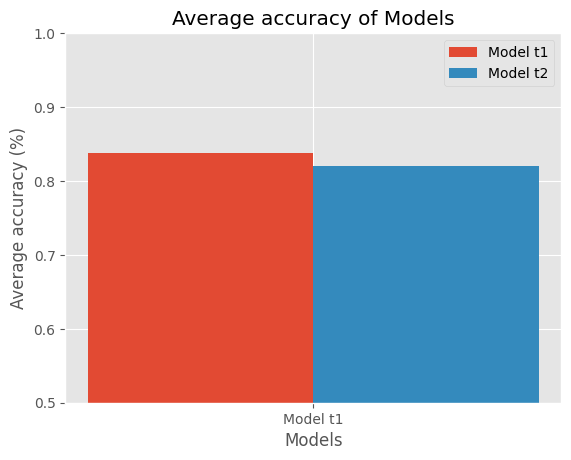

In [136]:
plt.style.use('ggplot')

chart_x1_t1 = ['Model t1']
chart_x1_t2 = ['Model t2']
chart_y1_t1 = [avg_accuracy_t1]
chart_y1_t2 = [avg_accuracy_t2]

chart_x1_pos = np.arange(1)

plt.ylim([0.5, 1])
plt.bar(chart_x1_pos - 0.2, chart_y1_t1, 0.4, label = 'Model t1')
plt.bar(chart_x1_pos + 0.2, chart_y1_t2, 0.4, label = 'Model t2')

plt.xlabel("Models")
plt.ylabel("Average accuracy (%)")
plt.title("Average accuracy of Models")

plt.xticks(chart_x1_pos, chart_x1)
plt.legend()
plt.show()



## 4.1 analyze average accuracy (each family) of 2 models

In [83]:
dict_2 = {}
dict_2['Family'] = ClassesList
dict_2['Model t1'] = avg_accuracies_t1_split
dict_2['Model t2'] = avg_accuracies_t2_split

table_2 = pd.DataFrame(data=dict_2)
table_2.style.hide_index()

Family,Model t1,Model t2
5_8S_rRNA,0.952000,0.948000
5S_rRNA,0.952000,0.948000
CD-box,0.905333,0.901333
HACA-box,0.859000,0.851000
Intron_gpI,0.863600,0.855200
Intron_gpII,0.885667,0.877000
IRES,0.851554,0.842339
leader,0.858859,0.847547
miRNA,0.836319,0.821153
riboswitch,0.836087,0.817838


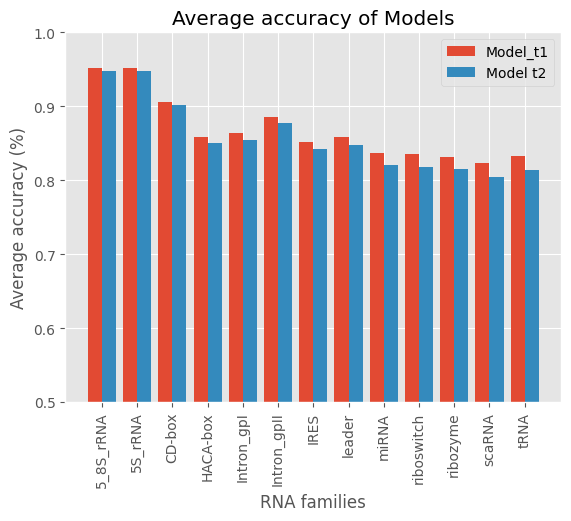

In [134]:
plt.style.use('ggplot')

chart_x2 = ClassesList
chart_y2_t1 = avg_accuracies_t1_split
chart_y2_t2 = avg_accuracies_t2_split
chart_x2_pos = np.arange(13)
plt.ylim([0.5, 1])
plt.bar(chart_x2_pos - 0.2, chart_y2_t1, 0.4, label = 'Model t1')
plt.bar(chart_x2_pos + 0.2, chart_y2_t2, 0.4, label = 'Model t2')

plt.xlabel("RNA families")
plt.ylabel("Average accuracy (%)")
plt.title("Average accuracy of Models")

plt.xticks(chart_x2_pos, chart_x2, rotation = 90)
plt.legend()
plt.show()

